In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# import signal_generation as sg
# import channel_model as ch
import hpcom
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
# from sklearn.externals import joblib
from datetime import datetime
from importlib import reload
reload(hpcom)


In [ ]:
df = pd.read_pickle('data/data_collected_extended_1.pkl')

In [ ]:
df

In [ ]:
df_for_ber = pd.read_pickle('data/data_collected_extended_2.pkl')
df_total = pd.concat([df, df_for_ber])
del df_for_ber


In [ ]:
df_for_ber = pd.read_pickle('data/data_collected_extended_2.pkl')
# df_for_ber.loc[:, ['z_km', 'p_ave_dbm', 'n_channels', 'ber_x']][(df['run'] == 0) & (df['n_channels'] == 1)]
df_for_ber

In [ ]:
df_ber = df_total[['p_ave_dbm', 'ber_x']][(df_total['run'] == 0)]
# df_plot = pd.DataFrame([df_ber['p_ave_dbm'], df_ber['ber_x'][0]], columns=['p_ave_dbm', 'ber_x'])
# df_plot
df_ber[['ber_x_value', 'ber_x_number']] = pd.DataFrame(df_ber['ber_x'].tolist(), index=df_ber.index)
df_ber['q_x'] = pd.DataFrame(np.sqrt(2) * sp.special.erfcinv(2 * df_ber['ber_x_value']), index=df_ber.index)
df_ber

In [ ]:
df_total.loc[:, ['z_km', 'p_ave_dbm', 'n_channels', 'ber_x']][(df['run'] == 0) & (df['n_channels'] == 1)]

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
# sns.set_style("darkgrid")
# sns.lineplot(data=df_ber, x="p_ave_dbm", y="ber_x_value")
sns.lineplot(data=df_ber, x="p_ave_dbm", y="q_x", marker='o')
plt.xlabel("Average pover [dBm]", fontsize= 12)
plt.ylabel("Q-factor", fontsize=12)
# plt.title("Persons vs Bill", fontsize= 15)

In [ ]:
df.loc[:, ['z_km', 'p_ave_dbm', 'n_channels', 'ber_x']][(df['run'] == 0) & (df['n_channels'] == 1)]

In [ ]:
df[(df['z_km'] == 10 * 80) & (df['p_ave_dbm'] == 6) & (df['n_channels'] == 1)].iloc[0]

In [ ]:
def get_grid(min, max, n):

    x = np.linspace(min, max, n)
    y = np.linspace(min, max, n)
    # full coordinate arrays
    return np.meshgrid(x, y)


def transform(points, scale):

    amplitudes = np.absolute(points)
    angles = np.angle(points)

    # amplitudes = amplitudes * (0.2 * amplitudes + np.absolute(angles) * 0.05)
    amplitudes = amplitudes * (scale * amplitudes)

    return amplitudes * np.exp(1.0j * angles)

def inverse_transform(points, scale):

    amplitudes = np.absolute(points)
    angles = np.angle(points)

    # amplitudes = amplitudes * (0.2 * amplitudes + np.absolute(angles) * 0.05)
    amplitudes = np.sqrt(amplitudes / scale)

    return amplitudes * np.exp(1.0j * angles)


# def get_m_neighbours(points, k, m):
#
#     point_minus_m = points[k - m]
#     point_plus_m = points[(k + m) % len(points)]
#
#     return point_minus_m, point_plus_m

def get_m_neighbours(points, m):

    n = len(points)
    points = np.concatenate((points[-m:], points, points[:m]))
    result = np.array([points[k-m:k+m+1] for k in range(m,n + m)], dtype=complex)
    return result


def get_shift_to_square(point, point_to_shift, r):

    x_center, y_center = point.real, point.imag
    x_point, y_point = point_to_shift.real, point_to_shift.imag

    x_left, x_right = x_center - r, x_center + r
    y_left, y_right = y_center - r, y_center + r

    if x_point < x_left:
        x_shift = x_left - x_point
    elif x_point > x_right:
        x_shift = x_right - x_point
    else:
        x_shift = 0

    if y_point < y_left:
        y_shift = y_left - y_point
    elif y_point > y_right:
        y_shift = y_right - y_point
    else:
        y_shift = 0

    return complex(x_shift, y_shift)

def get_shift_to_circle(points, points_to_shift, r):

    ind = np.where(np.absolute(points_to_shift - points) > r)
    shifts = np.zeros(len(points), dtype=complex)
    points_on_circle = r * np.exp(1.0j * np.angle(points_to_shift[ind] - points[ind])) + points[ind]
    shifts[ind] = points_on_circle - points_to_shift[ind]
    return shifts



def get_data_with_m_neighbor_old(df, z_km, p_ave_dbm, n_channels, run_list, m_neighbours):

    # Create dataframe (table) with following columns:
    # neighbor symbols from -M to M, current symbol
    # optional: z_km, p_ave_dbm, n_channels
    # predict absolute value and angle for correction shift (in 2 dimensional plane -> real and imag part of symbol)

    p_ave = (10 ** (p_ave_dbm / 10)) / 1000
    mod_type = sg.get_modulation_type_from_order(16)
    scale_constellation = sg.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave / 2)

    # columns = ['point_abs', 'point_angle', 'diff_abs', 'diff_angle']
    columns = ['point_orig_abs', 'point_orig_angle',
               'point_abs', 'point_angle',
               'diff_real', 'diff_imag',
               'diff_sq_real', 'diff_sq_imag',
               'diff_circle_real', 'diff_circle_imag']

    for m in range(1, m_neighbours + 1):
        columns = columns + [f'minus_m_{m}_abs', f'plus_m_{m}_abs', f'minus_m_{m}_angle', f'plus_m_{m}_angle']

    df_result = pd.DataFrame(columns=columns)
    # print(df_result)

    for run in run_list:
        df_current = df[(df['z_km'] == z_km) & (df['p_ave_dbm'] == p_ave_dbm) & (df['n_channels'] == n_channels) & (df['run'] == run)]

        points_x_orig = df_current['points_x_orig'].iloc[0][0]
        # points_x_orig = transform(points_x_orig, scale=400)
        points_x_shifted = df_current['points_x_shifted'].iloc[0]
        # points_x_shifted = transform(points_x_shifted, scale=400)
        points_diff = points_x_orig - points_x_shifted

        n_points = len(points_x_orig)
        points_diff_sq = np.zeros(n_points, dtype=complex)
        for k in range(n_points):
            points_diff_sq[k] = get_shift_to_square(points_x_orig[k], points_x_shifted[k], 0.5 / scale_constellation)

        points_diff_circle = get_shift_to_circle(points_x_orig, points_x_shifted, 0.5 / scale_constellation)

        for k in tqdm(range(len(points_x_shifted))):
        # for k in tqdm(range(100)):


            # row = np.array([np.absolute(points_x_shifted[k]), np.angle(points_x_shifted[k]),
            #                 np.absolute(points_diff[k]), np.angle(points_diff[k])])
            row = np.array([np.absolute(points_x_orig[k]), np.angle(points_x_orig[k]),
                            np.absolute(points_x_shifted[k]), np.angle(points_x_shifted[k]),
                            np.real(points_diff[k]), np.imag(points_diff[k]),
                            np.real(points_diff_sq[k]), np.imag(points_diff_sq[k]),
                            np.real(points_diff_circle[k]), np.imag(points_diff_circle[k])])
            for m in range(1, m_neighbours + 1):
                m_neighbours_points = get_m_neighbours(points_x_shifted, k, m)
                row = np.concatenate((row, np.absolute(m_neighbours_points), np.angle(m_neighbours_points)))

            # print(np.shape(row), row)
            # print(len(columns))

            df_result = pd.concat([df_result, pd.DataFrame([row], columns=columns)], ignore_index=True)
            # df_result = pd.DataFrame([row])

            # print(df_result)

    return df_result


def form_columns_names(m_neighbours, type='x'):

    columns = []

    for m in range(m_neighbours, 0, -1):
        columns = columns + [f'minus_m_{m}_' + type + '_abs']
    columns = columns + ['point_' + type + '_abs']
    for m in range(1, m_neighbours + 1):
        columns = columns + [f'plus_m_{m}_' + type + '_abs']

    for m in range(m_neighbours, 0, -1):
        columns = columns + [f'minus_m_{m}_' + type + '_angle']
    columns = columns + ['point_' + type + '_angle']
    for m in range(1, m_neighbours + 1):
        columns = columns + [f'plus_m_{m}_' + type + '_angle']

    return columns


def get_label_dict_for_constellation(constellation):

    dict = {}
    k = 0
    for point in constellation:
        dict[str(point)] = k
        k += 1

    dict_inv = {v: k for k, v in dict.items()}

    return dict, dict_inv


def get_labels_for_points(points, constellation):

    labels = np.zeros(len(points))
    dict, _ = get_label_dict_for_constellation(constellation)
    k = 0
    for p in points:
        labels[k] = dict[str(p)]
        k += 1

    return labels


def get_data_with_m_neighbor(df, z_km, p_ave_dbm, n_channels, run_list, m_neighbours, r=0.1, sigma=1.0, n_gauss=10):

    # Create dataframe (table) with following columns:
    # neighbor symbols from -M to M, current symbol
    # optional: z_km, p_ave_dbm, n_channels
    # predict absolute value and angle for correction shift (in 2 dimensional plane -> real and imag part of symbol)

    # seed = datetime.now()
    # np.random.seed(seed)

    p_ave = (10 ** (p_ave_dbm / 10)) / 1000
    mod_type = hpcom.modulation.get_modulation_type_from_order(16)
    scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave / 2)
    constellation = hpcom.modulation.get_constellation(mod_type)

    columns = ['point_orig_abs', 'point_orig_angle',
               'point_label',
               'diff_real', 'diff_imag',
               'diff_sq_real', 'diff_sq_imag',
               'diff_circle_real', 'diff_circle_imag',
               'diff_p3_real', 'diff_p3_imag']

    columns = columns + [f'diff_gauss_{m}_real' for m in range(n_gauss)]
    columns = columns + [f'diff_gauss_{m}_imag' for m in range(n_gauss)]

    columns = columns + form_columns_names(m_neighbours, type='x')
    columns = columns + form_columns_names(m_neighbours, type='y')

    print(columns)

    df_result = pd.DataFrame(columns=columns)
    # print(df_result)

    for run in run_list:
        print('run number', run)
        df_current = df[(df['z_km'] == z_km) & (df['p_ave_dbm'] == p_ave_dbm) & (df['n_channels'] == n_channels) & (df['run'] == run)]

        points_x_orig = df_current['points_x_orig'].iloc[0][0]
        points_x_scaled = hpcom.modulation.get_nearest_constellation_points_new(points_x_orig * scale_constellation, constellation)
        # points_x_labels_str = list(map(str, points_x_scaled))
        points_x_labels = get_labels_for_points(points_x_scaled, constellation)

        points_x_shifted = df_current['points_x_shifted'].iloc[0]
        points_x_with_neighbours = get_m_neighbours(points_x_shifted, m_neighbours)
        points_diff = points_x_orig - points_x_shifted

        print(np.shape(points_x_with_neighbours))

        # points_y_orig = df_current['points_y_orig'].iloc[0][0]
        points_y_shifted = df_current['points_y_shifted'].iloc[0]
        points_y_with_neighbours = get_m_neighbours(points_y_shifted, m_neighbours)
        # points_y_scaled = sg.get_nearest_constellation_points_new(points_y_orig * scale_constellation, constellation)




        n_points = len(points_x_orig)
        mu, sigma = 0, sigma / (3.0 * scale_constellation)
        # points_diff_gauss = points_diff + (np.random.normal(mu, sigma, n_points) + 1.0j * np.random.normal(mu, sigma, n_points))
        points_diff_gauss = np.tile(points_diff.reshape((n_points, 1)), (1, n_gauss)) + (np.random.normal(mu, sigma, (n_points, n_gauss)) +
                                                               1.0j * np.random.normal(mu, sigma, (n_points, n_gauss)))

        points_diff_sq = np.zeros(n_points, dtype=complex)
        for k in range(n_points):
            points_diff_sq[k] = get_shift_to_square(points_x_orig[k], points_x_shifted[k], r / scale_constellation)

        points_diff_circle = get_shift_to_circle(points_x_orig, points_x_shifted, r / scale_constellation)
        diff_p_real = np.power(np.real(points_diff) * 1.0 / scale_constellation, 3)
        diff_p_imag = np.power(np.imag(points_diff) * 1.0 / scale_constellation, 3)

        data = np.column_stack((np.absolute(points_x_orig), np.angle(points_x_orig),
                                points_x_labels,
                                np.real(points_diff), np.imag(points_diff),
                                np.real(points_diff_sq), np.imag(points_diff_sq),
                                np.real(points_diff_circle), np.imag(points_diff_circle),
                                diff_p_real, diff_p_imag,
                                np.real(points_diff_gauss), np.imag(points_diff_gauss),
                                np.absolute(points_x_with_neighbours), np.angle(points_x_with_neighbours),
                                np.absolute(points_y_with_neighbours), np.angle(points_y_with_neighbours)))

        # print(np.shape(data))

        df_result = pd.concat([df_result, pd.DataFrame(data, columns=columns)], ignore_index=True)

        # k = 1
        # one_row = [np.absolute(points_x_orig[k]), np.angle(points_x_orig[k]),
        #                         np.real(points_diff[k]), np.imag(points_diff[k]),
        #                         np.real(points_diff_sq[k]), np.imag(points_diff_sq[k]),
        #                         np.real(points_diff_circle[k]), np.imag(points_diff_circle[k])]
        # print(one_row, np.absolute(points_with_neighbours[k]), np.angle(points_with_neighbours[k]))
        # print(np.array(df_result.iloc[k]))
        # if np.isclose(np.array(df_result.iloc[0]), one_row):
        #     print('Error')



    return df_result


def get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, run_list, m_neighbours, r=0.1, sigma=1.0, n_gauss=10):

    # Create dataframe (table) with following columns:
    # neighbor symbols from -M to M, current symbol
    # optional: z_km, p_ave_dbm, n_channels
    # predict absolute value and angle for correction shift (in 2 dimensional plane -> real and imag part of symbol)

    # seed = datetime.now()
    # np.random.seed(seed)

    p_ave = (10 ** (p_ave_dbm / 10)) / 1000
    mod_type = hpcom.modulation.get_modulation_type_from_order(16)
    scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave / 2)
    constellation = hpcom.modulation.get_constellation(mod_type)

    columns = ['point_orig_abs', 'point_orig_angle',
               'point_label',
               'diff_real', 'diff_imag',
               'diff_sq_real', 'diff_sq_imag',
               'diff_circle_real', 'diff_circle_imag',
               'diff_p3_real', 'diff_p3_imag']

    columns = columns + [f'diff_gauss_real']
    columns = columns + [f'diff_gauss_imag']

    columns = columns + form_columns_names(m_neighbours, type='x')
    columns = columns + form_columns_names(m_neighbours, type='y')

    print(columns)

    df_result = pd.DataFrame(columns=columns)
    # print(df_result)

    for run in run_list:
        print('run number', run)
        df_current = df[(df['z_km'] == z_km) & (df['p_ave_dbm'] == p_ave_dbm) & (df['n_channels'] == n_channels) & (df['run'] == run)]

        points_x_orig = df_current['points_x_orig'].iloc[0][0]
        points_x_scaled = hpcom.modulation.get_nearest_constellation_points_new(points_x_orig * scale_constellation, constellation)
        # points_x_labels_str = list(map(str, points_x_scaled))
        points_x_labels = get_labels_for_points(points_x_scaled, constellation)

        points_x_shifted = df_current['points_x_shifted'].iloc[0]
        points_x_with_neighbours = get_m_neighbours(points_x_shifted, m_neighbours)
        points_diff = points_x_orig - points_x_shifted

        print(np.shape(points_x_with_neighbours))

        # points_y_orig = df_current['points_y_orig'].iloc[0][0]
        points_y_shifted = df_current['points_y_shifted'].iloc[0]
        points_y_with_neighbours = get_m_neighbours(points_y_shifted, m_neighbours)
        # points_y_scaled = sg.get_nearest_constellation_points_new(points_y_orig * scale_constellation, constellation)


        n_points = len(points_x_orig)
        mu, sigma = 0, sigma / (3.0 * scale_constellation)
        # points_diff_gauss = np.tile(points_diff.reshape((n_points, 1)), (1, 1)) + (np.random.normal(mu, sigma, (n_points, 1)) +
        #                                                        1.0j * np.random.normal(mu, sigma, (n_points, 1)))

        points_diff_sq = np.zeros(n_points, dtype=complex)
        for k in range(n_points):
            points_diff_sq[k] = get_shift_to_square(points_x_orig[k], points_x_shifted[k], r / scale_constellation)

        points_diff_circle = get_shift_to_circle(points_x_orig, points_x_shifted, r / scale_constellation)
        diff_p_real = np.power(np.real(points_diff) * 1.0 / scale_constellation, 3)
        diff_p_imag = np.power(np.imag(points_diff) * 1.0 / scale_constellation, 3)

        for k in range(n_gauss):
            points_diff_gauss = points_diff + (np.random.normal(mu, sigma, n_points) + 1.0j * np.random.normal(mu, sigma, n_points))

            data = np.column_stack((np.absolute(points_x_orig), np.angle(points_x_orig),
                                    points_x_labels,
                                    np.real(points_diff), np.imag(points_diff),
                                    np.real(points_diff_sq), np.imag(points_diff_sq),
                                    np.real(points_diff_circle), np.imag(points_diff_circle),
                                    diff_p_real, diff_p_imag,
                                    np.real(points_diff_gauss), np.imag(points_diff_gauss),
                                    np.absolute(points_x_with_neighbours), np.angle(points_x_with_neighbours),
                                    np.absolute(points_y_with_neighbours), np.angle(points_y_with_neighbours)))

            # print(np.shape(data))

            df_result = pd.concat([df_result, pd.DataFrame(data, columns=columns)], ignore_index=True)

        # k = 1
        # one_row = [np.absolute(points_x_orig[k]), np.angle(points_x_orig[k]),
        #                         np.real(points_diff[k]), np.imag(points_diff[k]),
        #                         np.real(points_diff_sq[k]), np.imag(points_diff_sq[k]),
        #                         np.real(points_diff_circle[k]), np.imag(points_diff_circle[k])]
        # print(one_row, np.absolute(points_with_neighbours[k]), np.angle(points_with_neighbours[k]))
        # print(np.array(df_result.iloc[k]))
        # if np.isclose(np.array(df_result.iloc[0]), one_row):
        #     print('Error')



    return df_result


# print(get_data_with_m_neighbor(df, 10 * 80, 6, 1, [0]))

In [ ]:
seed = int(datetime.now().timestamp())
np.random.seed(seed)

In [ ]:
df = pd.read_pickle('data/data_collected_3.pkl')

n_neighbours = 4
n_gauss = 5
# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_runs = [0, 1, 2, 3, 4, 5]
test_runs = [14, 15]

p_ave_dbm = 6
z_km = 80 * 20
n_channels = 1
sigma = 1.5

df_tree = get_data_with_m_neighbor(df, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, r=0.1, n_gauss=n_gauss)
df_tree_for_test = get_data_with_m_neighbor(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, r=0.1, n_gauss=n_gauss)

# df_tree = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, r=0.1, n_gauss=n_gauss, sigma=sigma)
# df_tree_for_test = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, r=0.1, n_gauss=1, sigma=sigma)

print(df_tree.head())
df = pd.DataFrame([])
del df

In [ ]:

labels_to_drop = ['point_orig_abs', 'point_orig_angle',
                  'point_label',
                  'diff_real', 'diff_imag',
                  'diff_sq_real', 'diff_sq_imag',
                  'diff_circle_real', 'diff_circle_imag',
                  'diff_p3_real', 'diff_p3_imag']

labels_to_drop = labels_to_drop + [f'diff_gauss_{m}_real' for m in range(n_gauss)]
labels_to_drop = labels_to_drop + [f'diff_gauss_{m}_imag' for m in range(n_gauss)]

# labels_to_drop = labels_to_drop + [f'diff_gauss_real']
# labels_to_drop = labels_to_drop + [f'diff_gauss_imag']

# label_predict = ['diff_circle_real', 'diff_circle_imag']
label_predict = ['diff_real', 'diff_imag']
m = 5
# label_predict = [f'diff_gauss_{m}_real', f'diff_gauss_{m}_imag']
# label_predict = [f'diff_gauss_real', f'diff_gauss_imag']
# label_predict = ['diff_p3_real', 'diff_p3_imag']
# label_predict = ['point_label']


In [ ]:
del X
del y_real
del y_imag

del X_for_test
del points_init_for_test

del X_train, X_test, y_real_train, y_real_test
del y_imag_train, y_imag_test
del po_abs_train, po_abs_test, po_angle_train, po_angle_test

In [ ]:
X_for_test = df_tree_for_test.drop(labels=labels_to_drop, axis=1)
points_init_for_test = df_tree_for_test['point_orig_abs'].values * np.exp(1.0j * df_tree_for_test['point_orig_angle'])
labels_for_test = df_tree_for_test['point_label']

In [ ]:
X_for_test.head()

In [ ]:
y = df_tree[[label_predict[0], label_predict[1]]].values

In [ ]:
# y = df_tree['diff_abs'].values
# y_angle = df_tree['diff_angle'].values

y_real = df_tree[label_predict[0]].values
y_imag = df_tree[label_predict[1]].values

In [ ]:
y_label = df_tree[label_predict[0]].values

In [ ]:
# X = df_tree.drop(labels=['diff_abs', 'diff_angle'], axis=1)
X = df_tree.drop(labels=labels_to_drop, axis=1)
X.head()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
# _, _, y_angle_train, y_angle_test = train_test_split(X, y_angle, test_size=0.2, random_state=20)

split_ratio = 0.01
random_state = 42

# X_train, X_test, y_real_train, y_real_test = train_test_split(X, y_real, test_size=split_ratio, random_state=random_state)
# _, _, y_imag_train, y_imag_test = train_test_split(X, y_imag, test_size=split_ratio, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=random_state)
po_abs_train, po_abs_test, po_angle_train, po_angle_test = train_test_split(df_tree['point_orig_abs'].values, df_tree['point_orig_angle'].values, test_size=split_ratio, random_state=random_state)

# print(np.shape(X_train), np.shape(X_test), np.shape(y_real_train), np.shape(y_real_test))

In [ ]:
split_ratio = 0.1
random_state = 21

X_train, X_test, y_label_train, y_label_test = train_test_split(X, y_label, test_size=split_ratio, random_state=random_state)
print(np.shape(X_train), np.shape(X_test), np.shape(y_label_train), np.shape(y_label_test))

In [ ]:
random_state_for_tree = 73
clf = RandomForestClassifier(n_estimators=100, max_depth=14, criterion="gini", verbose=2, n_jobs=12, random_state=random_state_for_tree)
clf.fit(X_train, y_label_train)

In [ ]:
y_label_pred = clf.predict(X_test)
print("Accuracy:",accuracy_score(y_label_test, y_label_pred))

y_label_pred_for_test = clf.predict(X_for_test)
print("Accuracy:",accuracy_score(labels_for_test, y_label_pred_for_test))

In [ ]:
def labels_to_points(labels, constellation):
    _, dict = get_label_dict_for_constellation(constellation)

    points = np.zeros(len(labels), dtype=complex)
    k = 0
    for l in labels:
        points[k] = complex(dict[l])
        k += 1

    return points


def predict_clf(model_clf, X_test, constellation):

    y_label_pred = model_clf.predict(X_test)
    return labels_to_points(y_label_pred, constellation)


def predict_clf_and_eval(model_clf, X_test, points_init, name='test', filename='log.txt'):

    p_ave_dbm_expl = 6
    p_ave_expl = (10 ** (p_ave_dbm_expl / 10)) / 1000
    mod_type = sg.get_modulation_type_from_order(16)
    scale_constellation = sg.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
    constellation = sg.get_constellation('16qam')

    points_orig = X_test['point_x_abs'].values * np.exp(1.0j * X_test['point_x_angle'].values)
    points_predict = predict_clf(model_clf, X_test, constellation)
    print(np.shape(points_orig), np.shape(points_predict))


    p_found_orig_for_test = sg.get_nearest_constellation_points_new(points_orig * scale_constellation, constellation)
    p_found_pred_for_test = sg.get_nearest_constellation_points_new(points_predict, constellation)

    ber_orig = sg.get_ber_by_points(points_init * scale_constellation, p_found_orig_for_test, '16qam')
    ber_predict = sg.get_ber_by_points(points_init * scale_constellation, p_found_pred_for_test, '16qam')

    q_orig = np.sqrt(2) * sp.special.erfcinv(2 * ber_orig[0])
    q_pred = np.sqrt(2) * sp.special.erfcinv(2 * ber_predict[0])
    q_orig_db = 20 * np.log10(q_orig)
    q_pred_db = 20 * np.log10(q_pred)
    evm_orig = sg.get_evm_rms_new(points_init, points_orig)
    evm_pred = sg.get_evm_rms_new(points_init, points_predict / scale_constellation)
    ber_evm_orig = sg.get_ber_from_evm(points_init, points_orig, 16)
    ber_evm_pred = sg.get_ber_from_evm(points_init, points_predict / scale_constellation, 16)

    name = name.center(len(name) + 10, '-')
    print_out = [name, f'Number of points {np.shape(points_init)}',
                 f'ber (orig / pred / delta) ({ber_orig} / {ber_predict} / {ber_orig[0] - ber_predict[0]})',
                 f'ber from EVM_rms (orig / pred / delta) ({ber_evm_orig} / {ber_evm_pred} / {ber_evm_orig - ber_evm_pred})',
                 f'q-factor [dB] (orig / pred / delta) ({q_orig_db} / {q_pred_db} / {q_pred_db - q_orig_db})',
                 f'EVM [%] (orig / pred / delta) ({evm_orig * 100.} / {evm_pred * 100.} / {(evm_orig - evm_pred) * 100}']

    f = open(filename, 'a')
    for line in print_out:
        print(line)
        f.write(line + '\n')

    f.close()

    return points_orig, points_predict

In [ ]:
_, _ = predict_clf_and_eval(clf, X_for_test, points_init_for_test, name='test', filename='log_clf.txt')

In [ ]:
X_for_test

In [ ]:
# model = RandomForestRegressor(max_depth=2, random_state=0)
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=0, n_jobs=13)
model.fit(X_train, y_train)

In [ ]:
model_angle = RandomForestRegressor(n_estimators=1000, max_depth=40, random_state=0, n_jobs=8)
model_angle.fit(X_train, y_angle_train)

In [ ]:
n_estimators = 20
random_state_for_tree = 73
start_time = datetime.now()
# model_real = RandomForestRegressor(n_estimators=400, max_depth=30, max_features=10, random_state=0, n_jobs=12, verbose=1)
# model_real = RandomForestRegressor(n_estimators=50, max_depth=30, random_state=0, n_jobs=12, verbose=1)
# model_real = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=12, verbose=1)
# model_real = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state_for_tree, n_jobs=13, verbose=1)
model_real.warm_start = True
model_real.n_estimators += n_estimators
model_real.fit(X_train, y_real_train)
print("model real took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

In [ ]:
start_time = datetime.now()
# model_imag = RandomForestRegressor(n_estimators=400, max_depth=30, max_features=10, random_state=0, n_jobs=12, verbose=1)
# model_imag = RandomForestRegressor(n_estimators=50, max_depth=30, random_state=0, n_jobs=12, verbose=1)
# model_imag = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state_for_tree, n_jobs=13, verbose=1)
model_imag.warm_start = True
model_imag.n_estimators += n_estimators
model_imag.fit(X_train, y_imag_train)
end_time = datetime.now()
print("model imag took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

In [ ]:
n_estimators = 300
random_state_for_tree = 73
start_time = datetime.now()
# model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state_for_tree, n_jobs=13, verbose=1)
model.warm_start = True
model.n_estimators += n_estimators
model.fit(X_train, y_train)
print("model real took", (datetime.now() - start_time).total_seconds() * 1000, "ms")


In [ ]:
n_to_train = 1000
start_time = datetime.now()
model_real_grad = GradientBoostingRegressor(n_estimators=1000, random_state=0, verbose=1)
model_real_grad.fit(X_train[:n_to_train], y_real_train[:n_to_train])
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000
print("model real grad took", execution_time, "ms")

In [ ]:
start_time = datetime.now()
model_imag_grad = GradientBoostingRegressor(n_estimators=1000, random_state=0, verbose=1)
model_imag_grad.fit(X_train[:n_to_train], y_imag_train[:n_to_train])
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000
print("model imag grad took", execution_time, "ms")

In [ ]:
y_pred = model.predict(X_test)
y_angle_pred = model_angle.predict(X_test)



mse_error = mean_squared_error(y_test, y_pred)
print(np.mean(y_test))
print(mse_error, mse_error / np.mean(y_test))

mse_error_angle = mean_squared_error(y_angle_test, y_angle_pred)
print(np.mean(y_angle_test))
print(mse_error_angle, mse_error_angle / np.mean(y_angle_test))

In [ ]:
y_real_pred = model_real.predict(X_test)
y_real_pred_train = model_real.predict(X_train)
y_imag_pred = model_imag.predict(X_test)
y_imag_pred_train = model_imag.predict(X_train)

mse_error_real_train = mean_squared_error(y_real_train, y_real_pred_train)
mse_error_real = mean_squared_error(y_real_test, y_real_pred)
print(mse_error_real_train, np.mean(y_real_train), mse_error_real_train / np.mean(y_real_train))
print(mse_error_real, np.mean(y_real_test), mse_error_real / np.mean(y_real_test))

mse_error_imag_train = mean_squared_error(y_imag_train, y_imag_pred_train)
mse_error_imag = mean_squared_error(y_imag_test, y_imag_pred)
print(mse_error_imag_train, np.mean(y_imag_train), mse_error_imag_train / np.mean(y_imag_train))
print(mse_error_imag, np.mean(y_imag_test), mse_error_imag / np.mean(y_imag_test))

In [ ]:
print(np.shape(y_real_pred), np.shape(y_imag_pred))

In [ ]:
y_pred, y_test

In [ ]:
y_angle_pred, y_angle_test

In [ ]:
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

feature_imp_angle = pd.Series(model_angle.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp_angle)

In [ ]:
import seaborn as sns

def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    # fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True))

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model_real.feature_importances_, feature_list, 'RF')

In [ ]:
feature_list = list(X.columns)
feature_imp_real = pd.Series(model_real.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp_real)

feature_imp_imag = pd.Series(model_imag.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp_imag)


In [ ]:
def transform(points, scale):
    return points

def inverse_transform(points, scale):
    return points

p_ave_dbm_expl = 6
p_ave_expl = (10 ** (p_ave_dbm_expl / 10)) / 1000
mod_type = sg.get_modulation_type_from_order(16)
scale_constellation = sg.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
# print(scale_constellation)
constellation = sg.get_constellation('16qam')
constellation_transformed = transform(constellation, scale=400)

points_orig = X_test['point_abs'].values * np.exp(1.0j * X_test['point_angle'].values)
# points_orig_transformed = transform(points_orig)
# points_predict = (np.absolute(points_orig_transformed) + y_pred) * np.exp(1.0j * (np.angle(points_orig_transformed) + y_angle_pred))
# points_predict = inverse_transform(points_predict)

points_orig_inv = inverse_transform(points_orig, scale=400)

print(np.mean(np.absolute(points_orig)), np.mean(np.absolute(points_orig_inv)))

# points_orig = X_test['point_abs'].values * np.exp(1.0j * X_test['point_angle'].values)
# points_predict = np.real(points_orig) + y_real_pred + 1.0j * (np.imag(points_orig) + y_imag_pred)
points_predict = np.real(points_orig) + y_real_pred + 1.0j * (np.imag(points_orig) + y_imag_pred)
points_predict_inv = inverse_transform(points_predict, scale=400)

points_init = po_abs_test * np.exp(1.0j * po_angle_test)

In [ ]:
p_found_orig = sg.get_nearest_constellation_points_new(points_orig_inv * scale_constellation, constellation)
p_found_pred = sg.get_nearest_constellation_points_new(points_predict_inv * scale_constellation, constellation)

ber_orig = sg.get_ber_by_points(points_init * scale_constellation, p_found_orig, '16qam')
ber_predict = sg.get_ber_by_points(points_init * scale_constellation, p_found_pred, '16qam')

print(ber_orig, ber_predict)

In [ ]:
print(np.mean(np.absolute(points_orig)), np.mean(np.absolute(points_orig_inv)))
print(20 / np.mean(np.absolute(points_orig_inv)))

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0][0].scatter(points_predict_inv.real * scale_constellation,
               points_predict_inv.imag * scale_constellation,
               s=10, c='blue', marker='*')
# axs[0].scatter(points_orig.real * scale_constellation,
#                points_orig.imag * scale_constellation,
#                s=20, color='xkcd:bright green', marker='.')
axs[0][0].scatter(constellation.real,
               constellation.imag,
               s=60, color='xkcd:bright red', marker='.')
axs[0][0].grid(True)


axs[0][1].scatter(points_orig_inv.real * scale_constellation,
               points_orig_inv.imag * scale_constellation,
               s=20, color='xkcd:bright green', marker='.')
axs[0][1].scatter(points_predict_inv.real * scale_constellation,
               points_predict_inv.imag * scale_constellation,
               s=10, c='blue', marker='*')
# axs[0][1].scatter(constellation.real,
#                   constellation.imag,
#                   s=60, color='xkcd:bright red', marker='.')
# axs[0][1].scatter(points_init.real * scale_constellation,
#                   points_init.imag * scale_constellation,
#                   s=60, color='xkcd:bright red', marker='.')
axs[0][1].grid(True)

axs[1][0].scatter(points_predict.real * scale_constellation,
               points_predict.imag * scale_constellation,
               s=10, c='blue', marker='*')
# axs[1][0].scatter(constellation.real,
#                constellation.imag,
#                s=20, color='xkcd:bright green', marker='.')
axs[1][0].grid(True)


axs[1][1].scatter(points_orig.real * scale_constellation,
               points_orig.imag * scale_constellation,
               s=20, color='xkcd:bright green', marker='.')
axs[1][1].scatter(points_predict.real * scale_constellation,
               points_predict.imag * scale_constellation,
               s=10, c='blue', marker='*')
# axs[1][1].scatter(constellation_transformed.real,
#                constellation_transformed.imag,
#                s=20, color='xkcd:bright green', marker='.')
axs[1][1].grid(True)

In [ ]:
# X_for_test
# points_init_for_test



def predict(model_real, model_imag, X_test, inverse_function=None, parameters=None):
    points_orig = X_test['point_x_abs'].values * np.exp(1.0j * X_test['point_x_angle'].values)
    if inverse_function == None:
        y_real_pred = model_real.predict(X_test)
        y_imag_pred = model_imag.predict(X_test)
    else:
        y_real_pred = inverse_function(model_real.predict(X_test), parameters[0])
        y_imag_pred = inverse_function(model_imag.predict(X_test), parameters[0])
    points_predict = np.real(points_orig) + y_real_pred + 1.0j * (np.imag(points_orig) + y_imag_pred)

    return points_predict


def predict_single(model, X_test, inverse_function=None, parameters=None):
    points_orig = X_test['point_x_abs'].values * np.exp(1.0j * X_test['point_x_angle'].values)
    if inverse_function == None:
        y_pred = model.predict(X_test)
    else:
        y_pred = inverse_function(model.predict(X_test), parameters[0])
    points_predict = np.real(points_orig) + y_pred[:,0] + 1.0j * (np.imag(points_orig) + y_pred[:,1])

    return points_predict


def inverse_p5(values, scale):
    return np.power(np.absolute(values), 1./5.) * np.sign(values) * scale


def inverse_p3(values, scale):
    return np.power(np.absolute(values), 1./3.) * np.sign(values) * scale


def predict_and_eval(model, X_test, points_init, name='test'):

    # p_ave_dbm_expl = 6
    p_ave_dbm_expl = p_ave_dbm
    print("P_ave [dBm] = ", p_ave_dbm_expl)
    p_ave_expl = (10 ** (p_ave_dbm_expl / 10)) / 1000
    mod_type = hpcom.modulation.get_modulation_type_from_order(16)
    scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
    constellation = hpcom.modulation.get_constellation('16qam')

    points_orig = X_test['point_x_abs'].values * np.exp(1.0j * X_test['point_x_angle'].values)
    # points_predict = predict(model_real, model_imag, X_test, inverse_function=inverse_p3, parameters=[scale_constellation])
    if len(model) == 2:
        points_predict = predict(model[0], model[1], X_test, inverse_function=None, parameters=None)
    else:
        points_predict = predict_single(model, X_test, inverse_function=None, parameters=None)



    p_found_orig_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_orig * scale_constellation, constellation)
    p_found_pred_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_predict * scale_constellation, constellation)

    ber_orig = hpcom.metrics.get_ber_by_points(points_init * scale_constellation, p_found_orig_for_test, '16qam')
    ber_predict = hpcom.metrics.get_ber_by_points(points_init * scale_constellation, p_found_pred_for_test, '16qam')

    q_orig = np.sqrt(2) * sp.special.erfcinv(2 * ber_orig[0])
    q_pred = np.sqrt(2) * sp.special.erfcinv(2 * ber_predict[0])
    q_orig_db = 20 * np.log10(q_orig)
    q_pred_db = 20 * np.log10(q_pred)
    evm_orig = hpcom.metrics.get_evm_rms_new(points_init, points_orig)
    evm_pred = hpcom.metrics.get_evm_rms_new(points_init, points_predict)
    ber_evm_orig = hpcom.metrics.get_ber_from_evm(points_init, points_orig, 16)
    ber_evm_pred = hpcom.metrics.get_ber_from_evm(points_init, points_predict, 16)

    name = name.center(len(name) + 10, '-')
    print_out = [name, f'Number of points {np.shape(points_init)}',
                 f'ber (orig / pred / delta) ({ber_orig} / {ber_predict} / {ber_orig[0] - ber_predict[0]})',
                 f'ber from EVM_rms (orig / pred / delta) ({ber_evm_orig} / {ber_evm_pred} / {ber_evm_orig - ber_evm_pred})',
                 f'q-factor [dB] (orig / pred / delta) ({q_orig_db} / {q_pred_db} / {q_pred_db - q_orig_db})',
                 f'EVM [%] (orig / pred / delta) ({evm_orig * 100.} / {evm_pred * 100.} / {(evm_orig - evm_pred) * 100}']

    f = open('log.txt', 'a')
    for line in print_out:
        print(line)
        f.write(line + '\n')

    f.close()

    return points_orig, points_predict


# points_orig_for_test, points_predict_for_test = predict_and_eval(model_real, model_imag, X_for_test, points_init_for_test, name='new data test')
# _ = predict_and_eval(model_real, model_imag, X_test, po_abs_test * np.exp(1.0j * po_angle_test), name='same data test')
# points_orig_train, points_predict_train = predict_and_eval(model_real, model_imag, X_train, po_abs_train * np.exp(1.0j * po_angle_train), name='same data train')

# points_orig_for_test, points_predict_for_test = predict_and_eval(model_real_grad, model_imag_grad, X_for_test, points_init_for_test)
# _ = predict_and_eval(model_real_grad, model_imag_grad, X_test, po_abs_test * np.exp(1.0j * po_angle_test))
# points_orig_train, points_predict_train = predict_and_eval(model_real_grad, model_imag_grad, X_train, po_abs_train * np.exp(1.0j * po_angle_train))


points_orig_for_test, points_predict_for_test = predict_and_eval(model, X_for_test, points_init_for_test, name='new data test')
_ = predict_and_eval(model, X_test, po_abs_test * np.exp(1.0j * po_angle_test), name='same data test')
points_orig_train, points_predict_train = predict_and_eval(model, X_train, po_abs_train * np.exp(1.0j * po_angle_train), name='same data train')

In [ ]:
# X_iter = X_for_test.drop(labels=['point_abs', 'point_angle'], axis=1)
X_iter = X_for_test.copy()
X_iter['point_abs'] = np.absolute(points_predict_for_test)
X_iter['point_angle'] = np.angle(points_predict_for_test)
points_orig_iter, points_predict_iter = predict_and_eval(model_real, model_imag, X_iter, points_init_for_test)


In [ ]:
print(np.sqrt(p_ave_expl / 2), np.sqrt(np.mean(np.power(np.absolute(points_init_for_test), 2))))

In [ ]:
p_ave_dbm_expl = p_ave_dbm
p_ave_expl = (10 ** (p_ave_dbm_expl / 10)) / 1000
mod_type = hpcom.modulation.get_modulation_type_from_order(16)
scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
constellation = hpcom.modulation.get_constellation('16qam')

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0][0].scatter(points_predict_for_test.real * scale_constellation,
               points_predict_for_test.imag * scale_constellation,
               s=10, c='blue', marker='*')
axs[0][0].scatter(constellation.real,
               constellation.imag,
               s=60, color='xkcd:bright red', marker='.')
# axs[0][0].scatter(points_predict_iter.real * scale_constellation,
#                points_predict_iter.imag * scale_constellation,
#                s=10, c='xkcd:purple', marker='*')
axs[0][0].grid(True)


axs[0][1].scatter(points_orig_for_test.real * scale_constellation,
               points_orig_for_test.imag * scale_constellation,
               s=20, color='xkcd:bright green', marker='.')
axs[0][1].scatter(points_predict_for_test.real * scale_constellation,
               points_predict_for_test.imag * scale_constellation,
               s=10, c='blue', marker='*')
axs[0][1].grid(True)


axs[1][0].scatter(points_predict_train.real * scale_constellation,
               points_predict_train.imag * scale_constellation,
               s=10, c='blue', marker='*')
axs[1][0].scatter(constellation.real,
               constellation.imag,
               s=60, color='xkcd:bright red', marker='.')
axs[1][0].grid(True)


axs[1][1].scatter(points_orig_train.real * scale_constellation,
               points_orig_train.imag * scale_constellation,
               s=20, color='xkcd:bright green', marker='.')
axs[1][1].scatter(points_predict_train.real * scale_constellation,
               points_predict_train.imag * scale_constellation,
               s=10, c='blue', marker='*')
axs[1][1].grid(True)

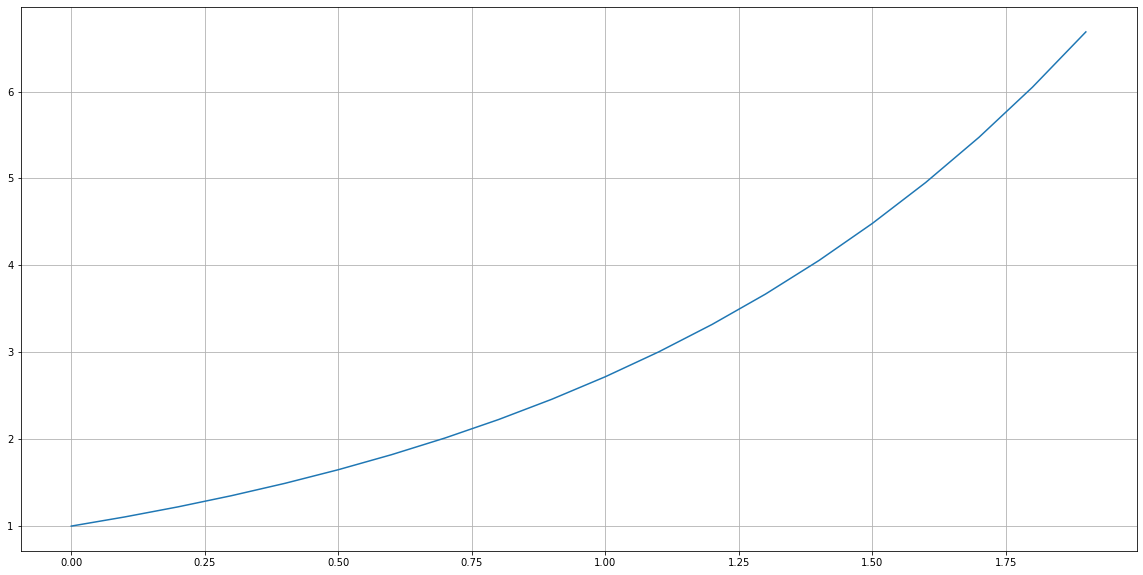

In [49]:
x_dist = np.arange(0, 2, 0.1)
y_dist = np.exp(x_dist)

fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.plot(x_dist, y_dist)
axs.grid(True)

In [8]:
df_run = df1[df1['run'] == 0]

In [35]:
points_x_orig = df_run['points_x_orig'].iloc[0][0]
print(np.shape(points_x_orig))
print(points_x_orig)
print(points_x_orig[(len(points_x_orig) - 1 + 3) % len(points_x_orig)])

(65536,)
[-0.01410864+0.04232591j  0.01410864+0.01410864j  0.04232591-0.04232591j
 ...  0.01410864+0.01410864j -0.04232591+0.04232591j
 -0.04232591+0.01410864j]
(0.042325905394813915-0.042325905394813915j)


In [141]:
points_orig_expl = df1.iloc[0]['points_x_orig'][0]
points_prop_expl = df1.iloc[0]['points_x_shifted']
p_ave_dbm_expl = df1.iloc[0]['p_ave_dbm']
p_ave_expl = (10 ** (p_ave_dbm_expl / 10)) / 1000

print(np.shape(points_orig_expl), np.shape(points_prop_expl))

(65536,) (65536,)


In [66]:
points_prop_expl

array([-0.02173733-0.00604307j, -0.01979429-0.02112313j,
        0.00635932+0.00692022j, ...,  0.01868031-0.00684389j,
        0.00616114-0.02164897j, -0.0063875 +0.00541388j])

In [142]:
mod_type = sg.get_modulation_type_from_order(16)
scale_constellation = sg.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)

print(scale_constellation)

70.87857830839414


In [143]:
def get_nearest_constellation_p(points, constellation):
    # constellation = get_constellation(mod_type)
    # diff = np.absolute(constellation - point * np.ones(len(constellation)))
    # ind = np.where(diff == np.amin(diff))
    # if len(constellation[ind]) > 1:
    #     return constellation[ind][0]
    # else:
    #     return constellation[ind]

    points = np.array(points)
    result = np.zeros(len(points), dtype=complex)

    n_tot = len(constellation)

    distance = [np.absolute(points - constellation[k]) for k in range(n_tot)]
    print(np.shape(distance))

    for p in range(n_tot):

        dist_check = [(distance[p] < distance[(p + k + 1) % n_tot]) for k in range(n_tot - 1)]

        log_res = np.logical_and(dist_check[0], dist_check[1])
        for k in range(2, n_tot - 1):
            log_res = np.logical_and(log_res, dist_check[k])
        pos = np.where(log_res)  # position for all point which is close to constellation[p]
        result[pos] = constellation[p]

    return result

In [144]:
constellation = sg.get_constellation('16qam')
print(constellation, len(constellation), constellation[-1])

p_found = get_nearest_constellation_p(points_prop_expl * scale_constellation, constellation)
print(np.shape(p_found))
print(np.shape(points_prop_expl), len(points_prop_expl) * 4)
# print(points_prop_expl)

ber = sg.get_ber_by_points(points_orig_expl * scale_constellation, p_found, '16qam')
print(ber)

[-1.-1.j -1.-3.j -1.+1.j -1.+3.j -3.-1.j -3.-3.j -3.+1.j -3.+3.j  1.-1.j
  1.-3.j  1.+1.j  1.+3.j  3.-1.j  3.-3.j  3.+1.j  3.+3.j] 16 (3+3j)
(16, 65536)
(65536,)
(65536,) 262144
(0.009288787841796875, 2435)


In [40]:
# ind = 0
# print(points_orig_expl[ind] * scale_constellation, p_found[ind])
# print(np.isclose(points_orig_expl[ind] * scale_constellation, p_found[ind]))
# print(points_orig_expl[ind] * scale_constellation == p_found[ind])

(-3-0.9999999999999999j) (-3-1j)
True
False


In [145]:
# I want to find position of points where we correctly found and incorrectly

pos_correct = np.where(np.isclose(points_orig_expl * scale_constellation, p_found))
pos_incorrect = np.where(~np.isclose(points_orig_expl * scale_constellation, p_found))

print(pos_correct, pos_incorrect)
print(len(points_orig_expl[pos_correct]), len(points_orig_expl[pos_incorrect]),
      len(points_orig_expl[pos_correct]) / len(points_orig_expl),
      len(points_orig_expl[pos_incorrect]) / len(points_orig_expl))


(array([    1,     2,     3, ..., 65533, 65534, 65535]),) (array([    0,   107,   113, ..., 65468, 65489, 65522]),)
63146 2390 0.963531494140625 0.036468505859375


In [146]:
print(np.sqrt(np.mean(np.power(np.absolute(points_orig_expl * scale_constellation), 2))))
print(sg.get_scale_coef_constellation('16qam'))
print(np.sqrt(p_ave_expl / 2))

t_one = np.sqrt(np.mean(np.power(np.absolute(points_orig_expl), 2)))
t_two = np.sqrt(np.mean(np.power(np.absolute(points_prop_expl), 2)))
print(t_one, t_two)
print(t_one / t_two)

print(16 * np.sqrt(np.sum(np.power(np.absolute(ft_filter_values), 2))))


3.1609649189369375
3.1622776601683795
0.04461542169214011
0.044596900705083486 0.04542302689212838
0.9818126125983018


NameError: name 'ft_filter_values' is not defined

In [118]:
# wdm = ch.create_wdm_parameters(n_channels=1, p_ave_dbm=0,
#                                     n_symbols=2 ** 16, m_order=16, roll_off=0.1, upsampling=16,
#                                     downsampling_rate=1, symb_freq=34e9, channel_spacing=75e9, n_polarisations=2,
#                                     seed='time')
#
# signal_x, signal_y, wdm_info = ch.generate_wdm_new(wdm)
# ft_filter_values = wdm_info['ft_filter_values_x']
#
# print(np.sum(np.absolute(ft_filter_values)))

2022-09-29 14:04:56.627784: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-29 14:04:56.630799: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-29 14:04:56.668637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 14:04:56.669050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-09-29 14:04:56.669080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-29 14:04:56.681688: I tensorflow/stream_executor/p

KeyboardInterrupt: 

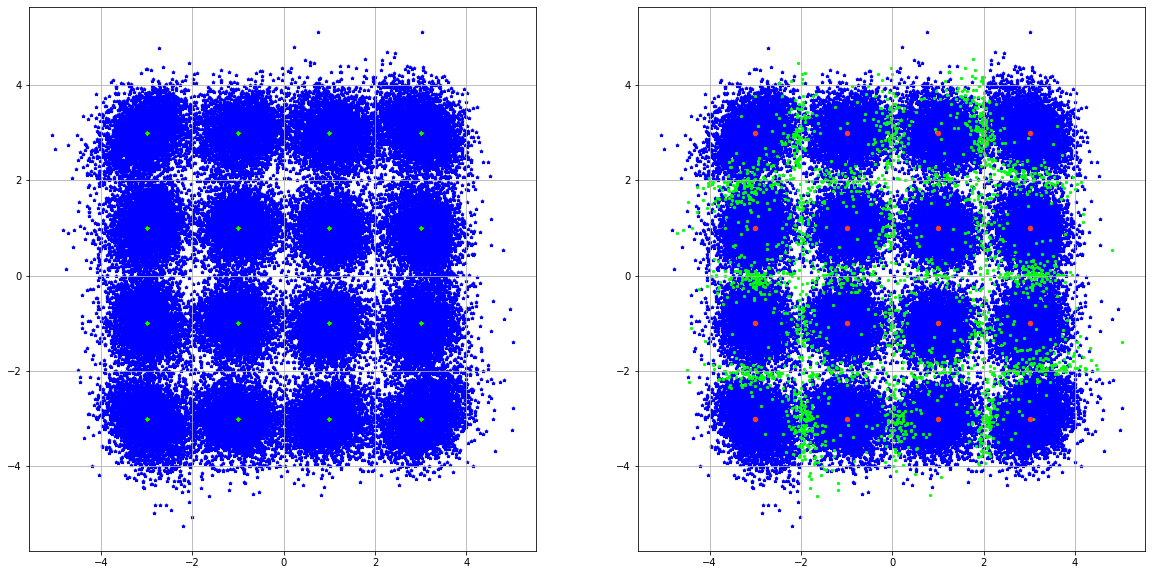

In [147]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(points_prop_expl.real * scale_constellation,
               points_prop_expl.imag * scale_constellation,
               s=10, c='blue', marker='*')
axs[0].scatter(points_orig_expl.real * scale_constellation,
               points_orig_expl.imag * scale_constellation,
               s=20, color='xkcd:bright green', marker='.')
axs[0].scatter(constellation.real,
               constellation.imag,
               s=20, color='xkcd:bright green', marker='.')
axs[0].grid(True)

axs[1].scatter(points_prop_expl[pos_correct].real * scale_constellation,
               points_prop_expl[pos_correct].imag * scale_constellation,
               s=10, c='blue', marker='*')
axs[1].scatter(points_prop_expl[pos_incorrect].real * scale_constellation,
               points_prop_expl[pos_incorrect].imag * scale_constellation,
               s=20, color='xkcd:bright green', marker='.')
axs[1].scatter(constellation.real,
               constellation.imag,
               s=20, color='xkcd:orange red', marker='o')
axs[1].grid(True)


# axs[1].scatter(constellation.real,
#                constellation.imag,
#                s=20, color='xkcd:bright green', marker='o')
# axs[1].scatter(p_found.real,
#                p_found.imag,
#                s=10, c='blue', marker='*')
# axs[1].grid(True)



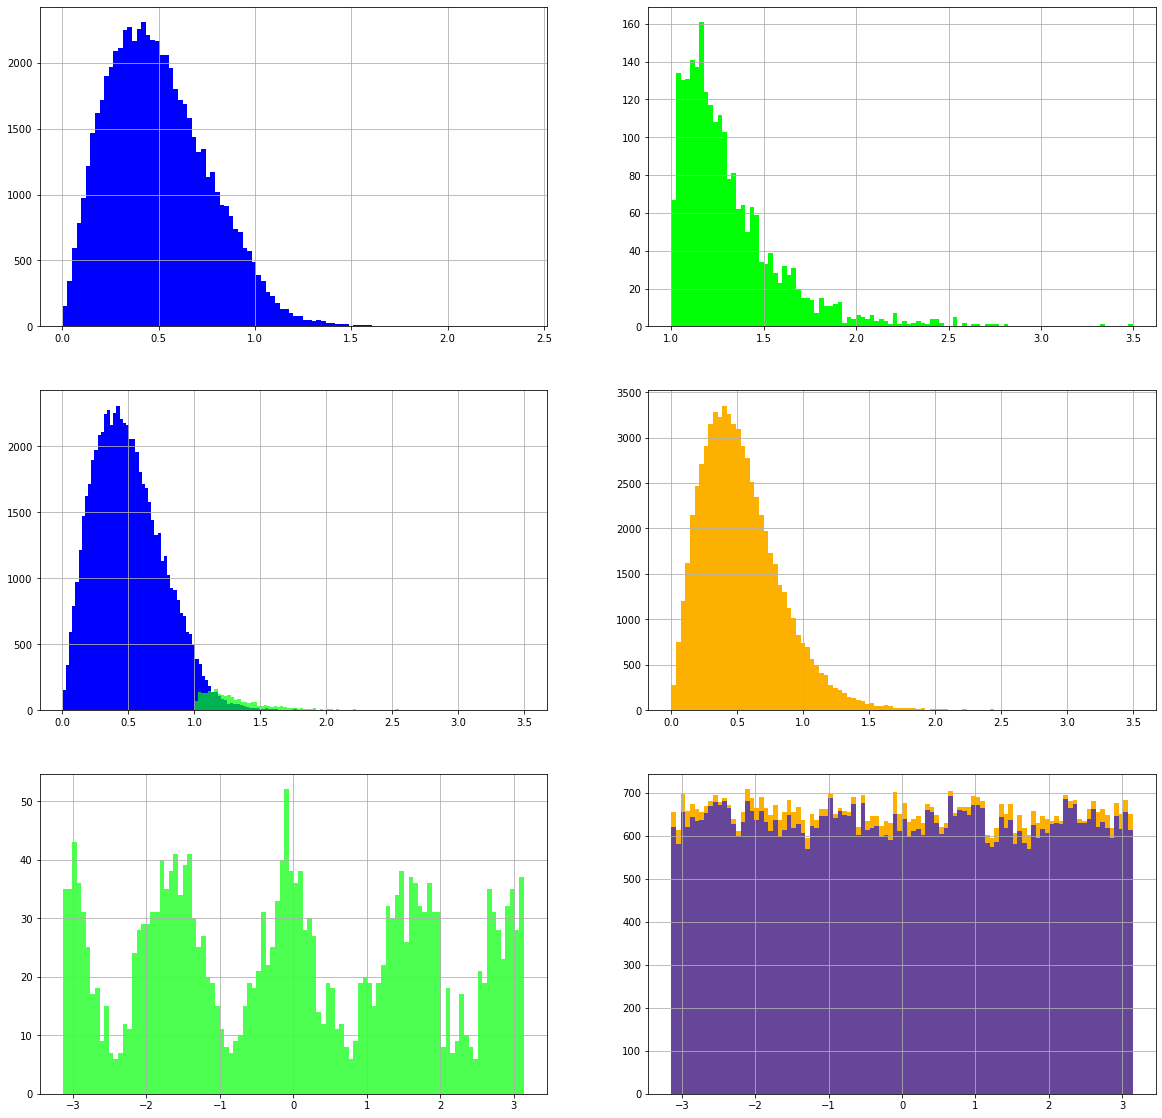

In [159]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs[0][0].hist(np.absolute(points_prop_expl[pos_correct] - points_orig_expl[pos_correct]) * scale_constellation,
            # density=True,
            bins=100,
            color='blue')
               # s=10, c='blue', marker='*')
axs[0][0].grid(True)

axs[0][1].hist(np.absolute(points_prop_expl[pos_incorrect] - points_orig_expl[pos_incorrect]) * scale_constellation,
            # density=True,
            bins=100,
            color='xkcd:bright green')
               # s=10, c='blue', marker='*')
axs[0][1].grid(True)

axs[1][0].hist(np.absolute(points_prop_expl[pos_correct] - points_orig_expl[pos_correct]) * scale_constellation,
            # density=True,
            bins=100,
            color='blue')
axs[1][0].hist(np.absolute(points_prop_expl[pos_incorrect] - points_orig_expl[pos_incorrect]) * scale_constellation,
            # density=True,
            bins=100,
            color='xkcd:bright green',
            alpha = 0.7)
               # s=10, c='blue', marker='*')
axs[1][0].grid(True)

# axs[1][1].hist(np.absolute(points_prop_expl - points_orig_expl) * scale_constellation,
#             # density=True,
#             bins=100,
#             color='blue')
axs[1][1].hist(np.absolute(points_prop_expl - points_orig_expl) * scale_constellation,
            # density=True,
            bins=100,
            color='xkcd:yellow orange',
            alpha = 1.0)
               # s=10, c='blue', marker='*')
axs[1][1].grid(True)




axs[2][0].hist(np.angle(points_prop_expl[pos_incorrect] - points_orig_expl[pos_incorrect]),
            # density=True,
            bins=100,
            color='xkcd:bright green',
            alpha = 0.7)
               # s=10, c='blue', marker='*')
axs[2][0].grid(True)

axs[2][1].hist(np.angle(points_prop_expl - points_orig_expl),
            # density=True,
            bins=100,
            color='xkcd:yellow orange',
            alpha = 1.0)
               # s=10, c='blue', marker='*')
axs[2][1].hist(np.angle(points_prop_expl[pos_correct] - points_orig_expl[pos_correct]),
            # density=True,
            bins=100,
            color='blue',
            alpha = 0.6)
axs[2][1].grid(True)

# axs[1].scatter(points_prop_expl[pos_correct].real * scale_constellation,
#                points_prop_expl[pos_correct].imag * scale_constellation,
#                s=10, c='blue', marker='*')
# axs[1].scatter(points_prop_expl[pos_incorrect].real * scale_constellation,
#                points_prop_expl[pos_incorrect].imag * scale_constellation,
#                s=20, color='xkcd:bright green', marker='.')
# axs[1].scatter(constellation.real,
#                constellation.imag,
#                s=20, color='xkcd:orange red', marker='o')
# axs[1].grid(True)
#
#
# plt.hist(x, density=True, bins=30)  # density=False would make counts
# plt.ylabel('Probability')
# plt.xlabel('Data');

In [171]:
n = 2 ** 16
a = (3 * np.random.random(n) - 1.5) + 1j * (3 * np.random.random(n) - 1.5)
b = np.array([1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j, 0, 0.5*(1 + 1j), 0.5*(1 - 1j), 0.5*(-1 + 1j), 0.5*(-1 - 1j)])
# print(a)



In [184]:
c = np.copy(b)
print(np.abs(c - 2j).min())
c[(c - 1).argmin()]

n_tot = len(b)

r = [abs(a - c[k]) for k in range(n_tot)]

sump = 0

for pp in range(9):
    # pos = np.where((r[pp] < r[(pp + 1) % 4]) & (r[pp] < r[(pp + 2) % 4]) & (r[pp] < r[(pp + 3) % 4]))

    kk = [(r[pp] < r[(pp + k + 1) % n_tot]) for k in range(n_tot-1)]
    # pos = np.where(kk[0] & kk[1] & kk[2])

    log_res = np.logical_and(kk[0], kk[1])
    for k in range(2, n_tot-1):
        log_res = np.logical_and(log_res, kk[k])
    pos = np.where(log_res)

    sump += len(a[pos])
# print(c)
# print(c[16 % 4])

print(sump, n)

1.4142135623730951
65536 65536


1.4142135623730951
[ 1. +1.j   1. -1.j  -1. +1.j  -1. -1.j   0. +0.j   0.5+0.5j  0.5-0.5j
 -0.5+0.5j -0.5-0.5j]
(1+1j)


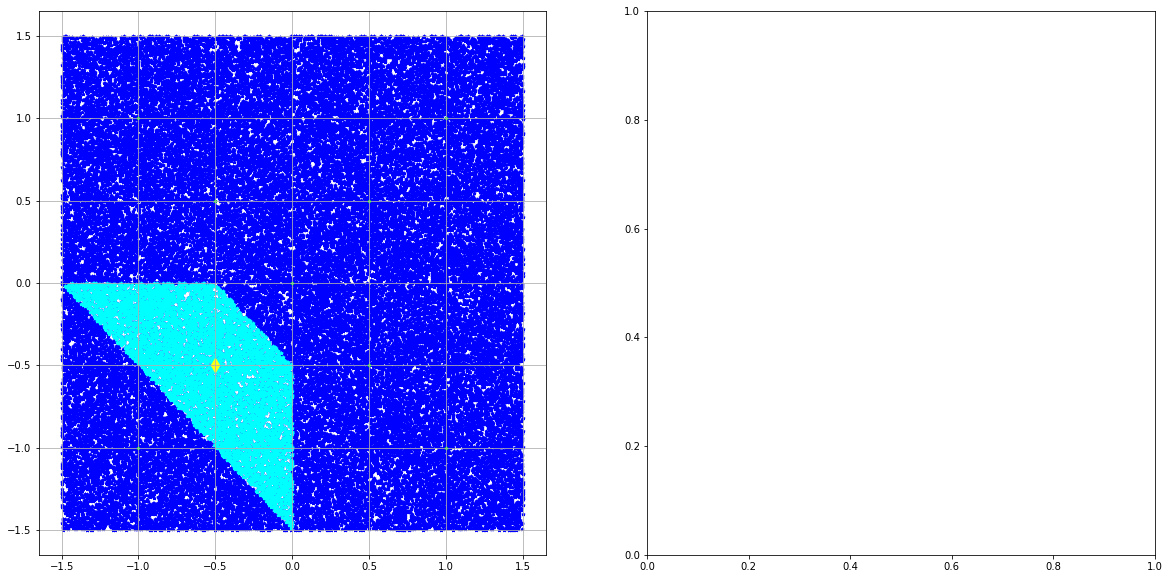

In [182]:


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(a.real,
               a.imag,
               s=10, c='blue', marker='*')
axs[0].scatter(a[pos].real,
               a[pos].imag,
               s=10, c='xkcd:cyan', marker='*')
axs[0].scatter(b.real,
               b.imag,
               s=20, color='xkcd:bright green', marker='.')
axs[0].scatter(c[pp].real,
               c[pp].imag,
               s=100, color='xkcd:yellow', marker='d')

axs[0].grid(True)

In [155]:
n = 2 ** 14
a = (3 * np.random.random(n) - 1.5) + 1j * (3 * np.random.random(n) - 1.5)
b = np.zeros(len(a), dtype=complex)

# for k in range(len(a)):
#     b[k] = a[k] + get_shift_to_square((-0.0 + 0.0j), a[k], 0.5)

b = a + get_shift_to_circle(np.full(len(a), (-0.0 + 0.0j)), a, 0.2)

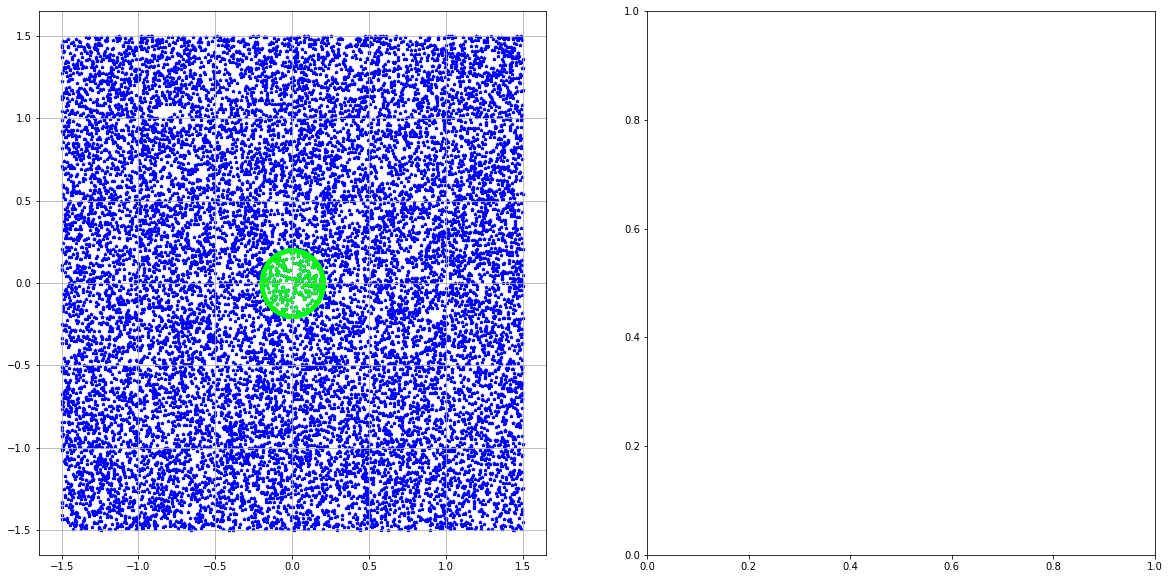

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(a.real,
               a.imag,
               s=10, c='blue', marker='*')
# axs[0].scatter(a[pos].real,
#                a[pos].imag,
#                s=10, c='xkcd:cyan', marker='*')
axs[0].scatter(b.real,
               b.imag,
               s=20, color='xkcd:bright green', marker='.')
# axs[0].scatter(c[pp].real,
#                c[pp].imag,
#                s=100, color='xkcd:yellow', marker='d')

axs[0].grid(True)